In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys; sys.path += ['..', '../src']

Now we gonna reproduce [Unsupervised Neural Machine Translation](https://arxiv.org/abs/1710.11041). What we need for this:
* Implement two decoders for Transformer
* Bring cross lingual embeddings alignment (from https://github.com/facebookresearch/MUSE, for example)
* Currently, we have to use full vocab, because we do not have strong embeddings for BPEs
* Implement corresponding Trainer class

In [3]:
import os
from src.vocab import Vocab

DATA_PATH = '../data/generated'
max_len = 50 # Processing long sentences is slow

train_src_path = os.path.join(DATA_PATH, 'train.en.tok')
train_trg_path = os.path.join(DATA_PATH, 'train.fr.tok')
val_src_path = os.path.join(DATA_PATH, 'val.en.tok')
val_trg_path = os.path.join(DATA_PATH, 'val.fr.tok')

train_src = open(train_src_path, 'r', encoding='utf-8').read().splitlines()
train_trg = open(train_trg_path, 'r', encoding='utf-8').read().splitlines()
val_src = open(val_src_path, 'r', encoding='utf-8').read().splitlines()
val_trg = open(val_trg_path, 'r', encoding='utf-8').read().splitlines()

vocab_src = Vocab.from_sequences(train_src)
vocab_trg = Vocab.from_sequences(train_trg)

# Simple preprocessing: crop lines and remove empty sentences
train_src = [s.split()[:max_len-2] for s in train_src if len(s) != 0]
train_trg = [s.split()[:max_len-2] for s in train_trg if len(s) != 0]
val_src = [s.split()[:max_len-2] for s in val_src if len(s) != 0]
val_trg = [s.split()[:max_len-2] for s in val_trg if len(s) != 0]

train_src_idx = [[vocab_src.token2id.get(t, vocab_src.unk) for t in s] for s in train_src]
train_trg_idx = [[vocab_trg.token2id.get(t, vocab_trg.unk) for t in s] for s in train_trg]
val_src_idx = [[vocab_src.token2id.get(t, vocab_src.unk) for t in s] for s in val_src]
val_trg_idx = [[vocab_trg.token2id.get(t, vocab_trg.unk) for t in s] for s in val_trg]

In [4]:
import os

from src.transformer.models import Transformer
from src.utils.data_utils import load_embeddings, init_emb_matrix
from src.models import SimpleTransformerClassifier

# transformer_kwargs = {'d_model': 512}
transformer_kwargs = {
    'n_layers': 2,
    'n_head': 2,
    'd_word_vec': 128,
    'd_model': 128,
    'd_inner_hid': 256,
    'd_k': 32,
    'd_v': 32
}
transformer = Transformer(len(vocab_src), len(vocab_trg), max_len, **transformer_kwargs)
discriminator = SimpleTransformerClassifier(2, max_len, **transformer_kwargs)

# Initializing transformer encoder and decoder with embeddings
# embeddings_src = load_embeddings('../trained_models/wiki.multi.en.vec')
# embeddings_trg = load_embeddings('../trained_models/wiki.multi.fr.vec')

# init_emb_matrix(transformer.encoder.src_word_emb.weight.data, embeddings_src, vocab_src.token2id)
# init_emb_matrix(transformer.decoder.tgt_word_emb.weight.data, embeddings_trg, vocab_trg.token2id)

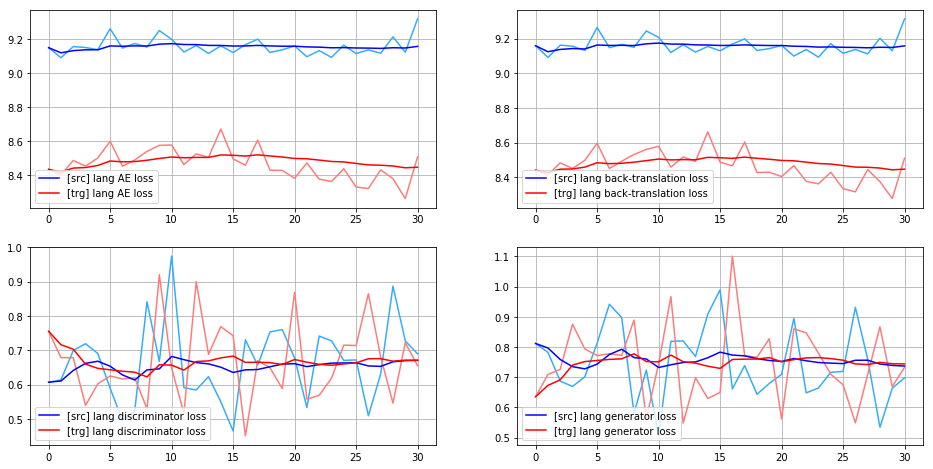

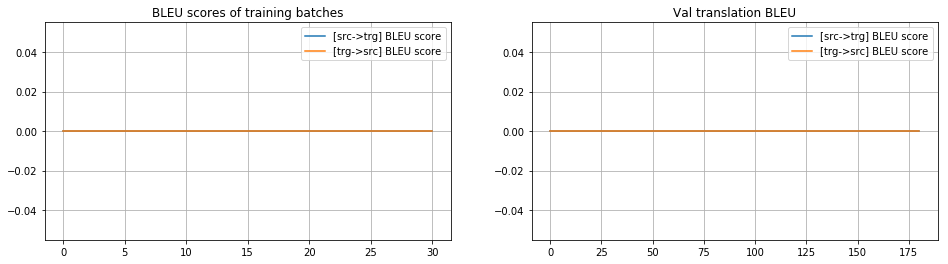

  0%|          | 32/14500 [00:34<4:20:16,  1.08s/it]


In [8]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.optim import Adam

%matplotlib inline

from src.umt_trainer import UMTTrainer
from src.utils.umt_batcher import UMTBatcher
from src.utils.batcher import Batcher
import src.transformer.constants as constants

use_cuda = torch.cuda.is_available()

def reconstruction_criterion(vocab_size):
    ''' With PAD token zero weight '''
    weight = torch.ones(vocab_size)
    weight[constants.PAD] = 0

    return nn.CrossEntropyLoss(weight)

reconstruct_src_criterion = reconstruction_criterion(len(vocab_src))
reconstruct_trg_criterion = reconstruction_criterion(len(vocab_trg))
adv_criterion = nn.BCEWithLogitsLoss()

def trainable_params_without_enc_embs(transformer):
    trainable = transformer.get_trainable_parameters()
    enc_embs = set(map(id, transformer.encoder.src_word_emb.parameters()))
    src_proj_embs = set(map(id, transformer.src_word_proj.parameters()))
    freezed = enc_embs | src_proj_embs

    return (p for p in trainable if not id(p) in freezed)

# transformer_optimizer = Adam([
#     {'params': transformer.get_trainable_params_without_embs(), 'lr': 1e-4},
#     {'params': transformer.get_embs_parameters(), 'lr': 1e-5}
# ])
transformer_optimizer = Adam(trainable_params_without_enc_embs(transformer), lr=1e-4)
discriminator_optimizer = Adam(discriminator.trainable_parameters(), lr=1e-4)

training_data = UMTBatcher(train_src_idx, train_trg_idx, vocab_src,
                           vocab_trg, batch_size=2, shuffle=False)
val_data = Batcher(val_src_idx[:2], val_trg_idx[:2], vocab_src.token2id,
                   vocab_trg.token2id, batch_size=2, shuffle=False)

training_config = {
    'max_num_epochs': 10,
    'start_bt_from_iter': 0
}

trainer = UMTTrainer(transformer, discriminator, vocab_src, vocab_trg,
                  transformer_optimizer, discriminator_optimizer,
                  reconstruct_src_criterion, reconstruct_trg_criterion, adv_criterion,
                  training_config)

trainer.run_training(training_data, val_data, plot_every=5, val_bleu_every=5)